## Real data: the case of ZTF19aainwvb

Public release only contain partial information about light-curves as objects keep being observed. In between two data release, the new data is only accessible to the public via brokers (unless one has data rights...). 

Hence we would like to know whether brokers, with their additional data, can go beyond data release results and lead to new results. We ask the question in the light of microlensing: can a broker discover a microlensing event that was previously not classified as such in data release?

For this, we will focus on one particular event, ZTF19aainwvb that is a good microlensing event. ZTF DR2 only captured the rising part of the event, and as we will see later in this notebook, it failed to consider the event as microlensing... Let's see what brokers will say!

In [1]:
import json
from astropy.time import Time

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd

from LIA import models
from LIA import microlensing_classifier

In [2]:
# For plots
font = {
    'weight': 'bold',
    'size': 22
}

matplotlib.rc('font', **font)

In [3]:
def dc_mag(fid, magpsf,sigmapsf, magnr,sigmagnr, magzpsci, isdiffpos):
    """ Compute apparent magnitude from difference magnitude supplied by ZTF
    Parameters
    
    Stolen from Lasair.
    
    ----------
    fid
        filter, 1 for green and 2 for red
    magpsf,sigmapsf
        magnitude from PSF-fit photometry, and 1-sigma error
    magnr,sigmagnr
        magnitude of nearest source in reference image PSF-catalog within 30 arcsec
        and 1-sigma error
    magzpsci
        Magnitude zero point for photometry estimates
    isdiffpos
        t or 1 => candidate is from positive (sci minus ref) subtraction; 
        f or 0 => candidate is from negative (ref minus sci) subtraction
    """

    # zero points. Looks like they are fixed.
    ref_zps = {1:26.325, 2:26.275, 3:25.660}
    magzpref = ref_zps[fid]

    # reference flux and its error
    magdiff = magzpref - magnr
    if magdiff > 12.0:
        magdiff = 12.0
    ref_flux = 10**( 0.4* ( magdiff) )
    ref_sigflux = (sigmagnr/1.0857)*ref_flux

    # difference flux and its error
    if magzpsci is None: magzpsci = magzpref
    magdiff = magzpsci - magpsf
    if magdiff > 12.0:
        magdiff = 12.0
    difference_flux = 10**( 0.4* ( magdiff) )
    difference_sigflux = (sigmapsf/1.0857)*difference_flux

    # add or subract difference flux based on isdiffpos
    if isdiffpos == 't': dc_flux = ref_flux + difference_flux
    else:                dc_flux = ref_flux - difference_flux

    # assumes errors are independent. Maybe too conservative.
    dc_sigflux =  np.sqrt( difference_sigflux**2 + ref_sigflux**2 )

    # apparent mag and its error from fluxes
    if (dc_flux == dc_flux) and dc_flux > 0.0:
        dc_mag = magzpsci - 2.5 * np.log10(dc_flux)
        dc_sigmag = dc_sigflux/dc_flux*1.0857
    else:
        dc_mag = magzpsci
        dc_sigmag = sigmapsf

    return dc_mag, dc_sigmag

## ZTF DR2 light-curves

Using the ZTF DR2 web interface, we make a cone-search around the location of the alert. There are 6 results, and we take the last two.

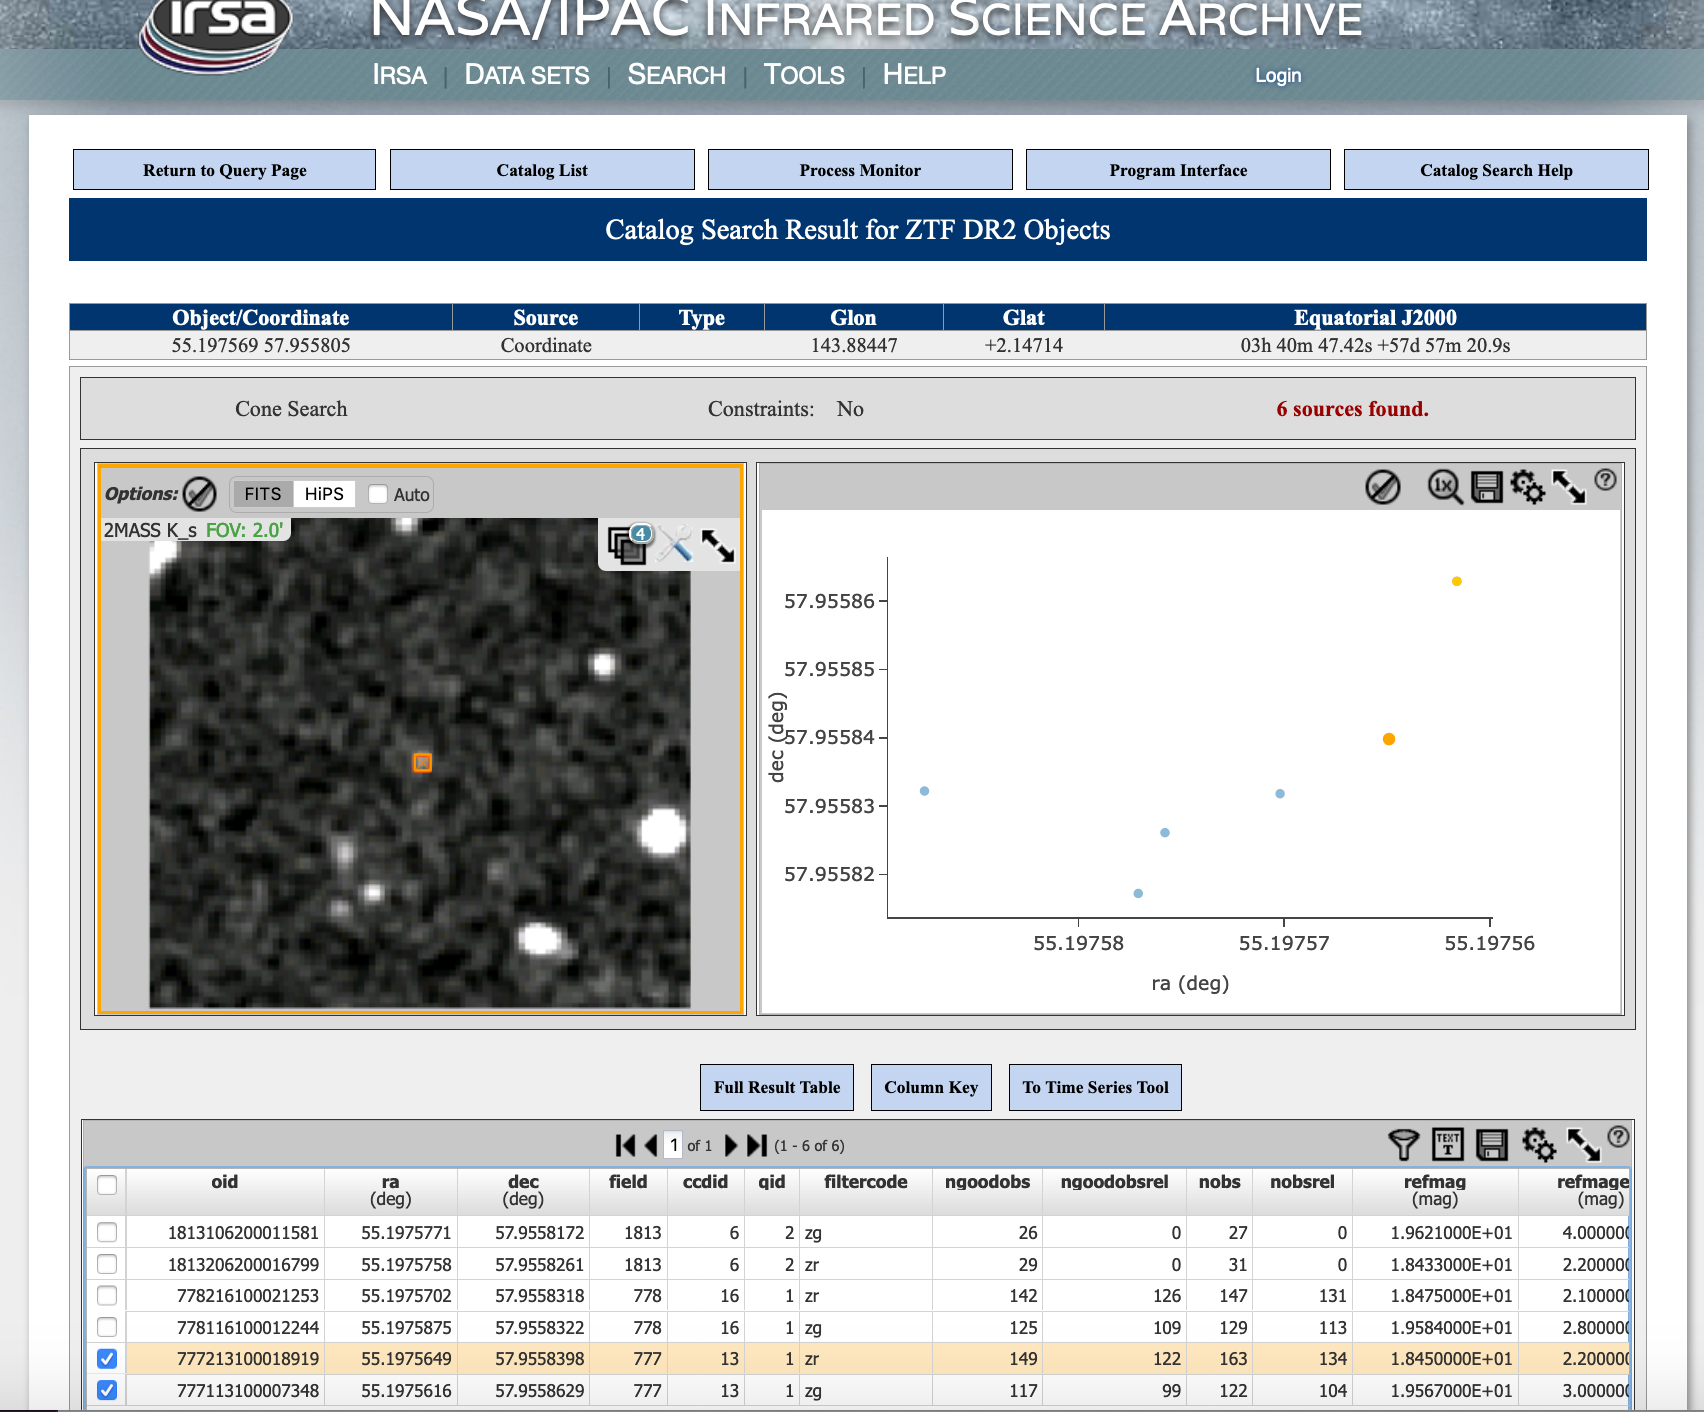

In [4]:
from IPython.display import Image
Image(filename='additional_data/dr2_query_screenshot.png')

In [5]:
# Magnitude that includes corrections
# for three photometric biasesthatdepend on: 
# (i)magnitude relative to PS1; 
# (ii)position (flat-fielding); and   
# (iii)survey field (sky location).
#For details,see: http://nesssi.cacr.caltech.edu/ZTF/Web/Calib.html
filenames = ['additional_data/dr2_gband_ZTF19aainwvb.csv', 'additional_data/dr2_rband_ZTF19aainwvb.csv']

dr2 = []
for filename in filenames:
    data = pd.read_csv(filename)
    data["filtercode"] = data["filtercode"].replace({"zg":1, "zr":2, "zi":3})
    mag = data.mag
    err = data.magerr
    jd = data.hjd
    fid = data.filtercode
    dr2.append(np.array([mag, err, jd, fid]))

## Additional broker data

Let's take data from brokers. We use data from Lasair https://lasair.roe.ac.uk/object/ZTF19aainwvb/

In [6]:
with open('additional_data/broker_allbands_ZTF19aainwvb.json', 'r') as f:
    raw_data = json.load(f)

# Extract fields
mag = np.array([float(i['magpsf']) for i in raw_data['candidates']], dtype=np.float32)
err = np.array([float(i['sigmapsf']) if 'sigmapsf' in i.keys() else None for i in raw_data['candidates']], dtype=np.float32)
magnr = np.array([float(i['magnr']) if 'magnr' in i.keys() else None for i in raw_data['candidates']], dtype=np.float32)
sigmagnr = np.array([float(i['sigmagnr']) if 'sigmagnr' in i.keys() else None for i in raw_data['candidates']], dtype=np.float32)
magzpsci = np.array([float(i['magzpsci']) if 'magzpsci' in i.keys() else None for i in raw_data['candidates']], dtype=np.float32)
isdiffpos = np.array([i['isdiffpos'] if 'isdiffpos' in i.keys() else None for i in raw_data['candidates']])
fid = np.array([i['fid'] for i in raw_data['candidates']])
jd = np.array([Time(i['utc']).jd for i in raw_data['candidates']])

# Select only valid measurements (not upper limits)
maskNotNone = np.where(err == err)[0]
mag = mag[maskNotNone]
err = err[maskNotNone]
fid = fid[maskNotNone]
jd = jd[maskNotNone]
sigmagnr = sigmagnr[maskNotNone]
magzpsci = magzpsci[maskNotNone]
isdiffpos = isdiffpos[maskNotNone]
magnr = magnr[maskNotNone]

# Compute DC mag
mag, err = np.array([
    dc_mag(i[0], i[1], i[2], i[3], i[4], i[5], i[6]) 
    for i in zip(fid, mag, err, magnr, sigmagnr, magzpsci, isdiffpos)
]).T

broker = []
for filt in [1, 2]: 
    mask = np.where(fid == filt)[0]
    broker.append(np.array([mag[mask][::-1], err[mask][::-1], jd[mask][::-1], fid[mask][::-1]]))

## Plot the two datasets

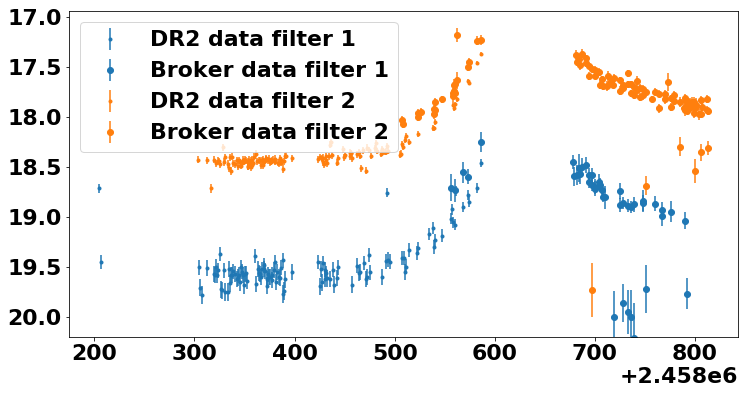

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
for filt, color in zip([0, 1], ['C0', 'C1']):
    plt.errorbar(
        dr2[filt][2], 
        dr2[filt][0], 
        yerr=dr2[filt][1], 
        ls='', marker='.', 
        color=color,
        label='DR2 data filter {}'.format(filt+1))
    plt.errorbar(
        broker[filt][2], 
        broker[filt][0], 
        yerr=broker[filt][1], 
        ls='', marker='o',
        color=color,
        label='Broker data filter {}'.format(filt+1))

plt.ylim([None, 20.2])
plt.gca().invert_yaxis()
plt.legend()
plt.show()

We can see a small offset between the two dataset in the region where they overlap. Different calibration? For time being, I will reject broker data that is overlaping with DR2 and take broker JDs beyond the last measurement of DR2.

## Classification

First let's create a composite event containing data from both datasets

In [8]:
# By eye...
jd_pivot = 2458650

composite = []
for filt in [0, 1]:
    jd_dr2 = dr2[filt][2]
    jd_broker = broker[filt][2]
    mask = np.where(jd_broker > jd_pivot)[0]
    composite.append([
        np.concatenate((dr2[filt][0],np.array(broker[filt][0])[mask])),
        np.concatenate((dr2[filt][1],np.array(broker[filt][1])[mask])),
        np.concatenate((dr2[filt][2],np.array(broker[filt][2])[mask])),
        np.concatenate((dr2[filt][3],np.array(broker[filt][3])[mask]))
    ])

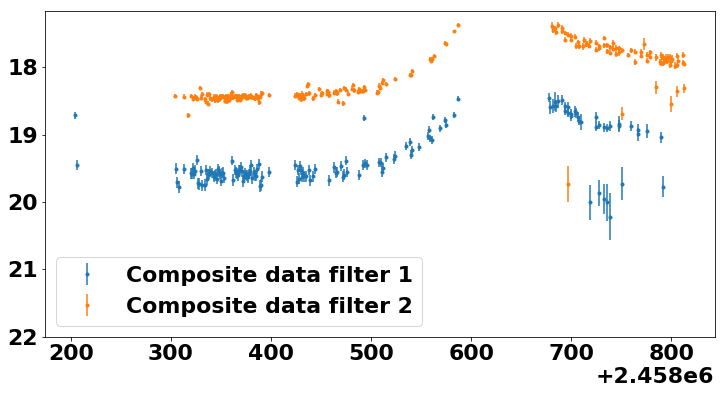

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
for filt, color in zip([0, 1], ['C0', 'C1']):
    plt.errorbar(
        composite[filt][2], 
        composite[filt][0], 
        yerr=composite[filt][1], 
        ls='', marker='.', 
        color=color,
        label='Composite data filter {}'.format(filt+1))

plt.ylim([None, 22])
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [10]:
import warnings
warnings.filterwarnings('ignore')

rf, pca = models.create_models('all_features.txt', 'pca_features.txt')
print('DR2 results only')
o1 = []
for filt in [0, 1]:
    output = microlensing_classifier.predict(dr2[filt][0], dr2[filt][1], rf, pca)
    print(output)
    o1.append(output[1:])
    
print('All results')
o2 = []
for filt in [0, 1]:
    output = microlensing_classifier.predict(composite[filt][0], composite[filt][1], rf, pca)
    print(output)
    o2.append(output[1:])

o1 = np.array(o1)
o2 = np.array(o2)

DR2 results only
('VARIABLE', array([0.27382482]), array([0.1364655]), array([0.24232495]), array([0.34738473]))
('VARIABLE', array([0.25875926]), array([0.15021088]), array([0.29473705]), array([0.29629281]))
All results
('ML', array([0.36519959]), array([0.16249322]), array([0.25314343]), array([0.21916376]))
('ML', array([0.35427074]), array([0.12484042]), array([0.28412282]), array([0.23676602]))


In [11]:
def make_spider(row: list, title: str, color: str):
    """ Make a radar plot, aka spider plot.
    
    stolen from matplotlib examples
    """
    # number of variable
    categories=list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(2,2,row+1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)

    # Ind1
    values=df.loc[row].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=11, color=color, y=1.1)


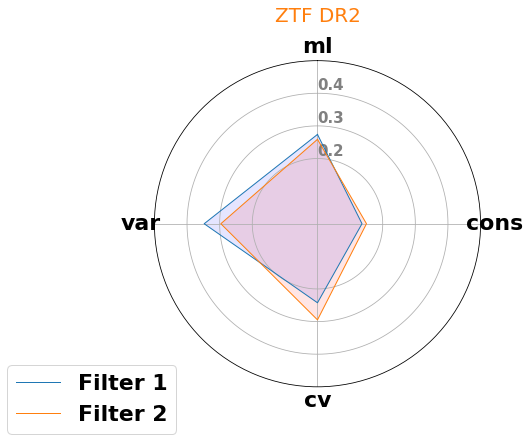

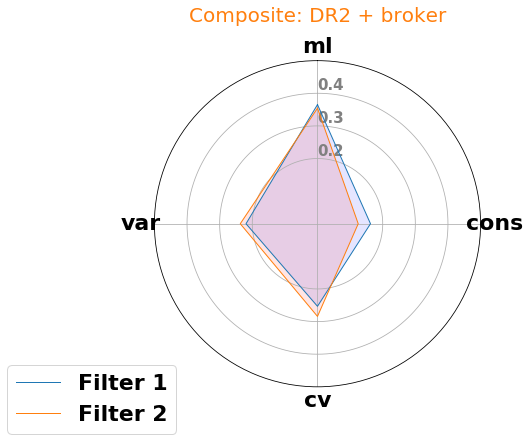

In [12]:
# Set data
df1 = pd.DataFrame({
    'group': ['filter1','filter2'],
    'ml': o1.T[0][0],
    'cons': o1.T[0][1],
    'cv': o1.T[0][2],
    'var': o1.T[0][3]
})

# Set data
df2 = pd.DataFrame({
    'group': ['filter1','filter2'],
    'ml': o2.T[0][0],
    'cons': o2.T[0][1],
    'cv': o2.T[0][2],
    'var': o2.T[0][3]
})

for o, title in zip([o1, o2], ['ZTF DR2', 'Composite: DR2 + broker']):
    # Set data
    df = pd.DataFrame({
    'group': ['filter1','filter2'],
        'ml': o.T[0][0],
        'cons': o.T[0][1],
        'cv': o.T[0][2],
        'var': o.T[0][3]
    })


    # ------- PART 1: Create background
    # number of variable
    categories=list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.2,0.3,0.4], ["0.2","0.3","0.4"], color="grey", size=15)
    plt.ylim(0,0.5)


    # ------- PART 2: Add plots
    # Ind1
    values=df.loc[0].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label="Filter 1")
    ax.fill(angles, values, 'b', alpha=0.1)

    # Ind2
    values=df.loc[1].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label="Filter 2")
    ax.fill(angles, values, 'r', alpha=0.1)

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title(title, size=20, color=color, y=1.1)
    plt.show()

Bingo! While DR2 sees no microlensing events, the inclusion of new data from broker allows to discriminate and flag it clearly as ML event in the 2 bands!